In [99]:
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict as odict

In [553]:
data = torch.randint(0, 10, (5,4,3,2))

def ndidx(t):
    '''
    Return a tensor of n-dimensional
    indices for the provided tensor.
    '''
    all_idx = []
    idx = torch.arange(t.numel())
    for size in t.shape[::-1]:
        all_idx.append(torch.remainder(idx, size))
        idx = torch.div(idx, size, rounding_mode='floor')
    return torch.stack(all_idx[::-1], dim=1)

def test_ndidx(t):
    idx = ndidx(t)
    flat_t = t.flatten()
    assert len(idx) == len(flat_t)
    for i, v in zip(idx, flat_t):
        assert v == t[tuple(i)]
        
def imshow(im):
    plt.imshow(im, vmin=0, vmax=1, cmap='gray')

test_ndidx(data)

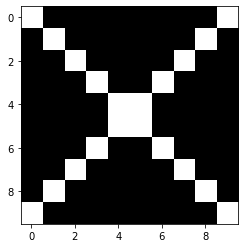

In [554]:
data = torch.eye(10) + torch.flip(torch.eye(10), dims=(0,))
imshow(data)

In [555]:
X = ndidx(data).float().cuda()
y = data.flatten().float().unsqueeze(1).cuda()
X_mean = X.mean(dim=0, keepdims=True)
y_mean = y.mean(dim=0, keepdims=True)

X.shape, y.shape

(torch.Size([100, 2]), torch.Size([100, 1]))

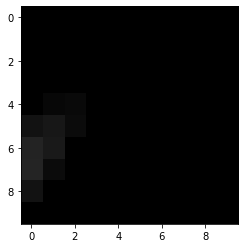

In [597]:
class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)
    
n_hidden = 5

model = nn.Sequential(
    nn.Linear(X.shape[1], n_hidden), Sine(),
    nn.Linear(n_hidden, n_hidden), Sine(),
    nn.Linear(n_hidden, 1)
).cuda()

y_pred = model(X - X_mean)
pred = (y_pred + y_mean).reshape(data.shape).detach().cpu().numpy()
imshow(pred)

In [598]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_steps = 10000
for i in range(n_steps+1):
    optimizer.zero_grad()
    y_pred = model.forward(X - X_mean)
    loss = F.mse_loss(y - y_mean, y_pred)
    if i % 1000 == 0:
        print(f'step = {i}, loss = {loss}')
    if i == n_steps:
        break
    loss.backward()
    optimizer.step()
        

step = 0, loss = 0.33237266540527344
step = 1000, loss = 0.12221017479896545
step = 2000, loss = 0.0660322904586792
step = 3000, loss = 0.03836256265640259
step = 4000, loss = 0.024547908455133438
step = 5000, loss = 0.013387787155807018
step = 6000, loss = 0.0006876972038298845
step = 7000, loss = 0.0003332094056531787
step = 8000, loss = 0.0003161371569149196
step = 9000, loss = 0.00031153284362517297
step = 10000, loss = 0.000308833085000515


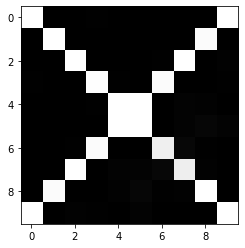

In [599]:
yhat = model.forward(X - X_mean)
pred = (yhat + y_mean).reshape(data.shape).detach().cpu().numpy()
imshow(pred)

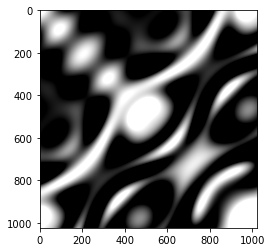

In [603]:
# super resolution
shape = (1024, 1024)
X_super = (
    ndidx(torch.zeros(*shape)).float() * torch.tensor(data.shape).unsqueeze(0) / torch.tensor(shape).unsqueeze(0)
).cuda()

y_super = model.forward(X_super - X_mean)
pred = (y_super + y_mean).reshape(tuple(shape)).detach().cpu().numpy()
imshow(pred)

In [601]:
n_params = 0
for p in model.parameters():
    n_params += p.numel()
n_params

51

In [592]:
n_super = 1
for size in shape:
    n_super *= size
n_super

4096